In [1]:
import os.path as osp

import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

from torch_geometric.utils import (negative_sampling, remove_self_loops,
                                   add_self_loops)
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, ChebConv, GINConv, GATConv  # noqa
from torch_geometric.utils import train_test_split_edges
import argparse
import numpy as np
import random
import os
from sklearn.metrics import roc_auc_score, f1_score
import json
from torch.nn import Sequential, ReLU, Linear
from tqdm import tqdm

torch.autograd.set_detect_anomaly(True)

class GradReverse(torch.autograd.Function):
    """
    Implement the gradient reversal layer for the convenience of domain adaptation neural network.
    The forward part is the identity function while the backward part is the negative function.
    """
    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg()

class GradientReversalLayer(torch.nn.Module):
    def __init__(self):
        super(GradientReversalLayer, self).__init__()

    def forward(self, inputs):
        return GradReverse.apply(inputs)

In [2]:
def sim(lambda_reg, seed):
    class Net(torch.nn.Module):
        def __init__(self, name='GCNConv'):
            super(Net, self).__init__()
            self.name = name
            if (name == 'GCNConv'):
                self.conv1 = GCNConv(dataset.num_features, 64)
                self.conv2 = GCNConv(64, 64)
                self.conv3 = GCNConv(64, 64)
            elif (name == 'ChebConv'):
                self.conv1 = ChebConv(dataset.num_features, 64, K=2)
                self.conv2 = ChebConv(64, 64, K=2)
                self.conv3 = ChebConv(64, 64, K=2)
            elif (name == 'GATConv'):
                self.conv1 = GATConv(dataset.num_features, 64)
                self.conv2 = GATConv(64, 64)
                self.conv3 = GATConv(64, 64)

            self.attr = GCNConv(64, dataset.num_classes, cached=True,
                                    normalize=not gdc)

            self.attack = GCNConv(64, dataset.num_classes, cached=True,
                                normalize=not gdc)
            self.reverse = GradientReversalLayer()

        def forward(self, pos_edge_index, neg_edge_index):

            if (self.name == 'GINConv'):
                x = F.relu(self.conv1(data.x, data.train_pos_edge_index))
                x = self.bn1(x)
                x = F.relu(self.conv2(x, data.train_pos_edge_index))
                x = self.bn2(x)
                x = F.relu(self.conv3(x, data.train_pos_edge_index))
                x = self.bn3(x)
            else:
                x = F.relu(self.conv1(data.x, data.train_pos_edge_index))
                x = self.conv2(x, data.train_pos_edge_index)
                x = self.conv3(x, data.train_pos_edge_index)

            feat = x
            attr = self.attr(x, edge_index, edge_weight)

            #print(feat.size())
            attack = self.reverse(x)
            att = self.attack(attack, edge_index, edge_weight)

            total_edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)
            x_j = torch.index_select(x, 0, total_edge_index[0])
            x_i = torch.index_select(x, 0, total_edge_index[1])

            """
            print(x_j.size())
            print(x_i.size())
            """

            res = torch.einsum("ef,ef->e", x_i, x_j)

            #print(res.size())
            return res, F.log_softmax(attr, dim=1), att, feat
    
    m = 'GCNConv' 
    lr = 0.01
    num_epochs = 200
    finetune_epochs = 100
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

    dataset = "Cora"
    path = osp.join('..', 'data', dataset)
    dataset = Planetoid(path, dataset, 'public', T.NormalizeFeatures())
    data = dataset[0]
    gdc = False

    labels = data.y.cuda()
    edge_index, edge_weight = data.edge_index.cuda(), data.edge_attr

    #print(labels.size())
    # Train/validation/test
    data = train_test_split_edges(data)

    #print(labels)

    device = torch.device('cuda')
    model, data = Net(m).cuda(), data.to("cuda")

    #if (m=='GINConv'):
    #    optimizer = torch.optim.Adam([
    #        dict(params=model.conv1.parameters(), weight_decay=0),
    #        dict(params=model.bn1.parameters(), weight_decay=0),
    #        dict(params=model.conv2.parameters(), weight_decay=0),
    #        dict(params=model.bn2.parameters(), weight_decay=0),
    #    ], lr=lr)
    #else:
    optimizer = torch.optim.Adam([
        dict(params=model.conv1.parameters(), weight_decay=0),
        dict(params=model.conv2.parameters(), weight_decay=0),
        dict(params=model.conv3.parameters(), weight_decay=0),
        dict(params=model.attr.parameters(), weight_decay=0)
    ], lr=lr)

    #if (m=='GINConv'):
    #    optimizer_att = torch.optim.Adam([
    #        dict(params=model.conv2.parameters(), weight_decay=5e-4), 
    #        dict(params=model.bn2.parameters(), weight_decay=0),  
    #        dict(params=model.attack.parameters(), weight_decay=5e-4),
    #    ], lr=lr * lambda_reg)
    #else:
    optimizer_att = torch.optim.Adam([
        dict(params=model.conv2.parameters(), weight_decay=5e-4),   
        dict(params=model.conv3.parameters(), weight_decay=5e-4),   
        dict(params=model.attack.parameters(), weight_decay=5e-4),
    ], lr=lr * lambda_reg)

    def get_link_labels(pos_edge_index, neg_edge_index):
        link_labels = torch.zeros(pos_edge_index.size(1) +
                                neg_edge_index.size(1)).float().to(device)
        link_labels[:pos_edge_index.size(1)] = 1.
        return link_labels

    global switch
    switch = True
    
    def train():
        global switch
        model.train()

        x, pos_edge_index = data.x, data.train_pos_edge_index

        _edge_index, _ = remove_self_loops(pos_edge_index)
        pos_edge_index_with_self_loops, _ = add_self_loops(_edge_index,
                                                        num_nodes=x.size(0))

        neg_edge_index = negative_sampling(
            edge_index=pos_edge_index_with_self_loops, num_nodes=x.size(0),
            num_neg_samples=pos_edge_index.size(1))

        link_logits, attr_prediction, attack_prediction,_ = model(pos_edge_index, neg_edge_index)
        link_labels = get_link_labels(pos_edge_index, neg_edge_index)

        loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
        one_hot = torch.cuda.FloatTensor(attack_prediction.size(0), attack_prediction.size(1)).zero_()
        mask = one_hot.scatter_(1, labels.view(-1,1), 1)
    
        nonzero = mask * attack_prediction
        avg = torch.mean(nonzero, dim = 0)
        loss2 = torch.abs(torch.max(avg) - torch.min(avg))
        
        if switch:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            switch = False
        else:
            optimizer_att.zero_grad()
            loss2.backward()
            optimizer_att.step()
            switch = True
            
            for p in model.attack.parameters():
                p.data.clamp_(-1, 1)
                
        return loss


    def test():
        model.eval()
        perfs = []
        for prefix in ["val", "test"]:
            pos_edge_index, neg_edge_index = [
                index for _, index in data("{}_pos_edge_index".format(prefix),
                                        "{}_neg_edge_index".format(prefix))
            ]
            link_probs = torch.sigmoid(model(pos_edge_index, neg_edge_index)[0])
            link_labels = get_link_labels(pos_edge_index, neg_edge_index)
            link_probs = link_probs.detach().cpu().numpy()
            link_labels = link_labels.detach().cpu().numpy()
            perfs.append(roc_auc_score(link_labels, link_probs))
        return perfs


    best_val_perf = test_perf = 0
    for epoch in range(1, num_epochs+1):
        train_loss = train()
        val_perf, tmp_test_perf = test()
        if val_perf > best_val_perf:
            best_val_perf = val_perf
            test_perf = tmp_test_perf
        log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'
        #print(log.format(epoch, train_loss, val_perf, tmp_test_perf))


    optimizer_attr = torch.optim.Adam([
        dict(params=model.attr.parameters(), weight_decay=5e-4),
    ], lr=lr)

    def train_attr():
        model.train()
        optimizer_attr.zero_grad()

        x, pos_edge_index = data.x, data.train_pos_edge_index

        _edge_index, _ = remove_self_loops(pos_edge_index)
        pos_edge_index_with_self_loops, _ = add_self_loops(_edge_index,
                                                        num_nodes=x.size(0))

        neg_edge_index = negative_sampling(
            edge_index=pos_edge_index_with_self_loops, num_nodes=x.size(0),
            num_neg_samples=pos_edge_index.size(1))

        F.nll_loss(model(pos_edge_index, neg_edge_index)[1][data.train_mask], labels[data.train_mask]).backward()
        optimizer_attr.step()


    @torch.no_grad()
    def test_attr():
        model.eval()
        accs = []
        m = ['train_mask', 'val_mask', 'test_mask']
        i = 0
        for _, mask in data('train_mask', 'val_mask', 'test_mask'):

            if (m[i] == 'train_mask') :
                x, pos_edge_index = data.x, data.train_pos_edge_index

                _edge_index, _ = remove_self_loops(pos_edge_index)
                pos_edge_index_with_self_loops, _ = add_self_loops(_edge_index,
                                                                num_nodes=x.size(0))

                neg_edge_index = negative_sampling(
                    edge_index=pos_edge_index_with_self_loops, num_nodes=x.size(0),
                    num_neg_samples=pos_edge_index.size(1))
            else:
                pos_edge_index, neg_edge_index = [
                index for _, index in data("{}_pos_edge_index".format(m[i].split("_")[0]),
                                        "{}_neg_edge_index".format(m[i].split("_")[0]))
                ]
            _, logits, _, _ = model(pos_edge_index, neg_edge_index)

            pred = logits[mask].max(1)[1]
            #acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
            #accs.append(acc)

            macro = f1_score((data.y[mask]).cpu().numpy(), pred.cpu().numpy(),average='macro')
            accs.append(macro)

            i+=1
        return accs

    if True:
        best_val_acc = test_acc = 0
        for epoch in range(1, finetune_epochs+1):
            train_attr()
            train_acc, val_acc, tmp_test_acc = test_attr()
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                test_acc = tmp_test_acc
            log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
            #print(log.format(epoch, train_acc, val_acc, tmp_test_acc))
    return train_loss, test_acc

In [3]:
res = {}
res_train = {}
for strength in tqdm(np.arange(0, 1, 0.05)):
    l = []
    lt = []
    for seed in [1,2,3,4,5]:
        loss, acc = sim(strength, seed)
        l.append(acc)
        lt.append(loss)
    res[strength] = l
    res_train[strength] = lt

100%|██████████| 20/20 [26:13<00:00, 78.68s/it]


In [4]:
res

{0.0: [0.737654508411536,
  0.729222455871682,
  0.721765330360558,
  0.7384688875758544,
  0.7125132207300051],
 0.05: [0.697605460663078,
  0.7090736386292328,
  0.7013623980623891,
  0.6925526728654047,
  0.6920898618560496],
 0.1: [0.6963805794954635,
  0.7017800199242006,
  0.7031467837662698,
  0.7043260539313438,
  0.6985169580599766],
 0.15000000000000002: [0.7030928134430626,
  0.6882535909246108,
  0.7045823498929098,
  0.7225382328847095,
  0.6896000993016439],
 0.2: [0.7005779566974395,
  0.6848665187869878,
  0.680929066652919,
  0.7037453579235103,
  0.6772512271246108],
 0.25: [0.599576783201524,
  0.6291159203106383,
  0.6792226709579628,
  0.7158237456671233,
  0.6327793370736142],
 0.30000000000000004: [0.5376785869714842,
  0.5848692394955644,
  0.6659232400613074,
  0.7033069745728554,
  0.39946521423158077],
 0.35000000000000003: [0.41335962573269486,
  0.5437490785076837,
  0.6284557690624437,
  0.679960406578525,
  0.3782769784254588],
 0.4: [0.36024207100424427,

In [5]:
import seaborn as sns

In [6]:
def sim_orig(lambda_reg, seed):
    class Net(torch.nn.Module):
        def __init__(self, name='GCNConv'):
            super(Net, self).__init__()
            self.name = name
            if (name == 'GCNConv'):
                self.conv1 = GCNConv(dataset.num_features, 64)
                self.conv2 = GCNConv(64, 64)
                self.conv3 = GCNConv(64, 64)
            elif (name == 'ChebConv'):
                self.conv1 = ChebConv(dataset.num_features, 64, K=2)
                self.conv2 = ChebConv(64, 64, K=2)
                self.conv3 = ChebConv(64, 64, K=2)
            elif (name == 'GATConv'):
                self.conv1 = GATConv(dataset.num_features, 64)
                self.conv2 = GATConv(64, 64)
                self.conv3 = GATConv(64, 64)

            self.attr = GCNConv(64, dataset.num_classes, cached=True,
                                    normalize=not gdc)

            self.attack = GCNConv(64, dataset.num_classes, cached=True,
                                normalize=not gdc)
            self.reverse = GradientReversalLayer()

        def forward(self, pos_edge_index, neg_edge_index):

            if (self.name == 'GINConv'):
                x = F.relu(self.conv1(data.x, data.train_pos_edge_index))
                x = self.bn1(x)
                x = F.relu(self.conv2(x, data.train_pos_edge_index))
                x = self.bn2(x)
                x = F.relu(self.conv3(x, data.train_pos_edge_index))
                x = self.bn3(x)
            else:
                x = F.relu(self.conv1(data.x, data.train_pos_edge_index))
                x = self.conv2(x, data.train_pos_edge_index)
                x = self.conv3(x, data.train_pos_edge_index)

            feat = x
            attr = self.attr(x, edge_index, edge_weight)

            #print(feat.size())
            attack = self.reverse(x)
            att = self.attack(attack, edge_index, edge_weight)

            total_edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)
            x_j = torch.index_select(x, 0, total_edge_index[0])
            x_i = torch.index_select(x, 0, total_edge_index[1])

            """
            print(x_j.size())
            print(x_i.size())
            """

            res = torch.einsum("ef,ef->e", x_i, x_j)

            #print(res.size())
            return res, F.log_softmax(attr, dim=1), F.log_softmax(att, dim=1), feat
    
    m = 'GCNConv' 
    lr = 0.01
    num_epochs = 200
    finetune_epochs = 100
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

    dataset = "Cora"
    path = osp.join('..', 'data', dataset)
    dataset = Planetoid(path, dataset, 'public', T.NormalizeFeatures())
    data = dataset[0]
    gdc = False
    #if gdc:
    #    gdc = T.GDC(self_loop_weight=1, normalization_in='sym',
    #                normalization_out='col',
    #                diffusion_kwargs=dict(method='ppr', alpha=0.05),
    #                sparsification_kwargs=dict(method='topk', k=128,
    #                                        dim=0), exact=True)
    #    data = gdc(data)

    labels = data.y.cuda()
    edge_index, edge_weight = data.edge_index.cuda(), data.edge_attr

    #print(labels.size())
    # Train/validation/test
    data = train_test_split_edges(data)

    #print(labels)

    device = torch.device('cuda')
    model, data = Net(m).cuda(), data.to("cuda")

    #if (m=='GINConv'):
    #    optimizer = torch.optim.Adam([
    #        dict(params=model.conv1.parameters(), weight_decay=0),
    #        dict(params=model.bn1.parameters(), weight_decay=0),
    #        dict(params=model.conv2.parameters(), weight_decay=0),
    #        dict(params=model.bn2.parameters(), weight_decay=0),
    #    ], lr=lr)
    #else:
    optimizer = torch.optim.Adam([
        dict(params=model.conv1.parameters(), weight_decay=0),
        dict(params=model.conv2.parameters(), weight_decay=0),
        dict(params=model.conv3.parameters(), weight_decay=0),
        dict(params=model.attr.parameters(), weight_decay=0)
    ], lr=lr)

    #if (m=='GINConv'):
    #    optimizer_att = torch.optim.Adam([
    #        dict(params=model.conv2.parameters(), weight_decay=5e-4), 
    #        dict(params=model.bn2.parameters(), weight_decay=0),  
    #        dict(params=model.attack.parameters(), weight_decay=5e-4),
    #    ], lr=lr * lambda_reg)
    #else:
    optimizer_att = torch.optim.Adam([
        dict(params=model.conv2.parameters(), weight_decay=5e-4),   
        dict(params=model.conv3.parameters(), weight_decay=5e-4),   
        dict(params=model.attack.parameters(), weight_decay=5e-4),
    ], lr=lr * lambda_reg)

    def get_link_labels(pos_edge_index, neg_edge_index):
        link_labels = torch.zeros(pos_edge_index.size(1) +
                                neg_edge_index.size(1)).float().to(device)
        link_labels[:pos_edge_index.size(1)] = 1.
        return link_labels

    global switch
    switch = True
    
    def train():
        global switch
        model.train()

        x, pos_edge_index = data.x, data.train_pos_edge_index

        _edge_index, _ = remove_self_loops(pos_edge_index)
        pos_edge_index_with_self_loops, _ = add_self_loops(_edge_index,
                                                        num_nodes=x.size(0))

        neg_edge_index = negative_sampling(
            edge_index=pos_edge_index_with_self_loops, num_nodes=x.size(0),
            num_neg_samples=pos_edge_index.size(1))

        link_logits, attr_prediction, attack_prediction,_ = model(pos_edge_index, neg_edge_index)
        link_labels = get_link_labels(pos_edge_index, neg_edge_index)

        loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
        loss2 = F.nll_loss(attack_prediction, labels)
        
        if switch:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            switch = False
        else:
            optimizer_att.zero_grad()
            loss2.backward()
            optimizer_att.step()
            switch = True
            
            for p in model.attack.parameters():
                p.data.clamp_(-1, 1)

        return loss


    def test():
        model.eval()
        perfs = []
        for prefix in ["val", "test"]:
            pos_edge_index, neg_edge_index = [
                index for _, index in data("{}_pos_edge_index".format(prefix),
                                        "{}_neg_edge_index".format(prefix))
            ]
            link_probs = torch.sigmoid(model(pos_edge_index, neg_edge_index)[0])
            link_labels = get_link_labels(pos_edge_index, neg_edge_index)
            link_probs = link_probs.detach().cpu().numpy()
            link_labels = link_labels.detach().cpu().numpy()
            perfs.append(roc_auc_score(link_labels, link_probs))
        return perfs


    best_val_perf = test_perf = 0
    for epoch in range(1, num_epochs+1):
        train_loss = train()
        val_perf, tmp_test_perf = test()
        if val_perf > best_val_perf:
            best_val_perf = val_perf
            test_perf = tmp_test_perf
        log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'
        #print(log.format(epoch, train_loss, val_perf, tmp_test_perf))


    optimizer_attr = torch.optim.Adam([
        dict(params=model.attr.parameters(), weight_decay=5e-4),
    ], lr=lr)

    def train_attr():
        model.train()
        optimizer_attr.zero_grad()

        x, pos_edge_index = data.x, data.train_pos_edge_index

        _edge_index, _ = remove_self_loops(pos_edge_index)
        pos_edge_index_with_self_loops, _ = add_self_loops(_edge_index,
                                                        num_nodes=x.size(0))

        neg_edge_index = negative_sampling(
            edge_index=pos_edge_index_with_self_loops, num_nodes=x.size(0),
            num_neg_samples=pos_edge_index.size(1))

        F.nll_loss(model(pos_edge_index, neg_edge_index)[1][data.train_mask], labels[data.train_mask]).backward()
        optimizer_attr.step()


    @torch.no_grad()
    def test_attr():
        model.eval()
        accs = []
        m = ['train_mask', 'val_mask', 'test_mask']
        i = 0
        for _, mask in data('train_mask', 'val_mask', 'test_mask'):

            if (m[i] == 'train_mask') :
                x, pos_edge_index = data.x, data.train_pos_edge_index

                _edge_index, _ = remove_self_loops(pos_edge_index)
                pos_edge_index_with_self_loops, _ = add_self_loops(_edge_index,
                                                                num_nodes=x.size(0))

                neg_edge_index = negative_sampling(
                    edge_index=pos_edge_index_with_self_loops, num_nodes=x.size(0),
                    num_neg_samples=pos_edge_index.size(1))
            else:
                pos_edge_index, neg_edge_index = [
                index for _, index in data("{}_pos_edge_index".format(m[i].split("_")[0]),
                                        "{}_neg_edge_index".format(m[i].split("_")[0]))
                ]
            _, logits, _, _ = model(pos_edge_index, neg_edge_index)

            pred = logits[mask].max(1)[1]
            #acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
            #accs.append(acc)

            macro = f1_score((data.y[mask]).cpu().numpy(), pred.cpu().numpy(),average='macro')
            accs.append(macro)

            i+=1
        return accs

    if True:
        best_val_acc = test_acc = 0
        for epoch in range(1, finetune_epochs+1):
            train_attr()
            train_acc, val_acc, tmp_test_acc = test_attr()
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                test_acc = tmp_test_acc
            log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
            #print(log.format(epoch, train_acc, val_acc, tmp_test_acc))
    return train_loss, test_acc

In [7]:
res2 = {}
res2_train = {}
for strength in tqdm(np.arange(0, 1, 0.05)):
    l = []
    lt = []
    for seed in [1,2,3,4,5]:
        loss, acc = sim_orig(strength, seed)
        l.append(acc)
        lt.append(loss)
    res2[strength] = l
    res2_train[strength] = lt

100%|██████████| 20/20 [27:00<00:00, 81.02s/it]


<AxesSubplot:>

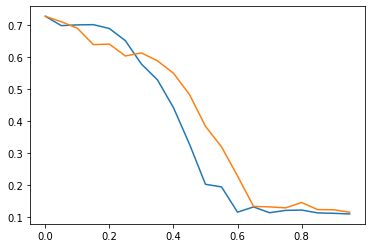

In [8]:
agg = {k: sum(v)/len(v) for k,v in res.items()}
agg2 = {k: sum(v)/len(v) for k,v in res2.items()}
sns.lineplot(x=agg.keys(), y=agg.values(), legend="full")
sns.lineplot(x=agg2.keys(), y=agg2.values(), legend="full")

<AxesSubplot:>

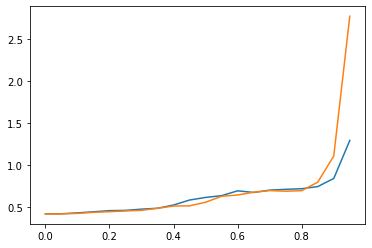

In [9]:
agg3 = {k: float((sum(v)/len(v)).detach().cpu().numpy()) for k,v in res_train.items()}
agg4 = {k: float((sum(v)/len(v)).detach().cpu().numpy()) for k,v in res2_train.items()}
sns.lineplot(x=agg3.keys(), y=agg3.values(), legend="full")
sns.lineplot(x=agg4.keys(), y=agg4.values(), legend="full")

In [10]:
print(res,res2,res_train,res2_train)

{0.0: [0.737654508411536, 0.729222455871682, 0.721765330360558, 0.7384688875758544, 0.7125132207300051], 0.05: [0.697605460663078, 0.7090736386292328, 0.7013623980623891, 0.6925526728654047, 0.6920898618560496], 0.1: [0.6963805794954635, 0.7017800199242006, 0.7031467837662698, 0.7043260539313438, 0.6985169580599766], 0.15000000000000002: [0.7030928134430626, 0.6882535909246108, 0.7045823498929098, 0.7225382328847095, 0.6896000993016439], 0.2: [0.7005779566974395, 0.6848665187869878, 0.680929066652919, 0.7037453579235103, 0.6772512271246108], 0.25: [0.599576783201524, 0.6291159203106383, 0.6792226709579628, 0.7158237456671233, 0.6327793370736142], 0.30000000000000004: [0.5376785869714842, 0.5848692394955644, 0.6659232400613074, 0.7033069745728554, 0.39946521423158077], 0.35000000000000003: [0.41335962573269486, 0.5437490785076837, 0.6284557690624437, 0.679960406578525, 0.3782769784254588], 0.4: [0.36024207100424427, 0.5025318193005465, 0.49757652598198365, 0.6273975798430905, 0.22095679

In [11]:
res_t = {k : [float(i.detach().cpu().numpy()) for i in v] for k,v in res_train.items()}
res_t2 = {k : [float(i.detach().cpu().numpy()) for i in v] for k,v in res2_train.items()}

In [14]:
import pandas as pd
x = []
y = []
l = []
for k, v in res.items():
    x.extend([k for _ in v])
    y.extend(v)
    l.extend(['Wasserstein' for _ in v])
d = {'lambda': x, 'macro_f1': y, 'method': l}
df = pd.DataFrame(data=d)

x = []
y = []
l = []
for k, v in res2.items():
    x.extend([k for _ in v])
    y.extend(v)
    l.extend(['TV' for _ in v])
d = {'lambda': x, 'macro_f1': y, 'method': l}
df2 = pd.DataFrame(data=d)

df3 = pd.concat([df,df2])

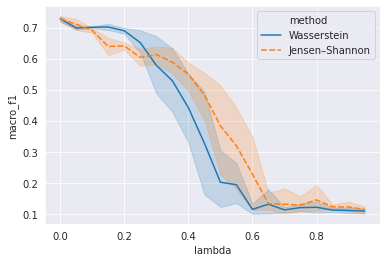

In [15]:
sns.set_style("darkgrid")
ax = sns.lineplot(data=df3, x="lambda", y="macro_f1", hue="method", style="method")

In [16]:
ax.figure.savefig('f1_cora.pdf')

In [17]:
import pandas as pd
x = []
y = []
l = []
for k, v in res_t.items():
    x.extend([k for _ in v])
    y.extend(v)
    l.extend(['Wasserstein' for _ in v])
d = {'lambda': x, 'loss': y, 'method': l}
df = pd.DataFrame(data=d)

x = []
y = []
l = []
for k, v in res_t2.items():
    x.extend([k for _ in v])
    y.extend(v)
    l.extend(['TV' for _ in v])
d = {'lambda': x, 'loss': y, 'method': l}
df2 = pd.DataFrame(data=d)

df3 = pd.concat([df,df2])

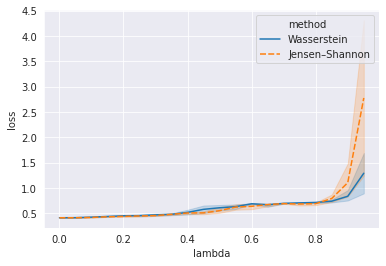

In [18]:
sns.set_style("darkgrid")
ax = sns.lineplot(data=df3, x="lambda", y="loss", hue="method", style="method")

In [19]:
ax.figure.savefig('loss_cora.pdf')